# DANA 4830 team project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as st

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.image import imread


from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn import metrics

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline

import os
import scipy.io

In [2]:
# fig configurations
sns.set(color_codes=True)
plt.rcParams["figure.figsize"] = [10,4]
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams.update({'legend.fontsize': 15})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'font.size': 20})

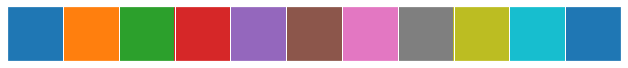

In [3]:
cpalette = sns.color_palette('tab10', 11)
sns.palplot(cpalette)

In [4]:
# savefig
def savePNG(f):
    fName = f+".png"
    fPath = os.path.join("figures",fName)
    plt.savefig(fPath, dpi=300)
    
# save df as csv
def saveCSV(f,fName):
    fName2 = fName+".csv"
    fPath = os.path.join("data",fName2)
    f.to_csv(fPath)

# 2020 data

In [5]:
d20 = pd.read_csv(os.path.join("data", "d20Master.csv"), index_col=0)

In [6]:
d20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108085 entries, 0 to 108084
Columns: 213 entries, AS to q64.13
dtypes: float64(213)
memory usage: 176.5 MB


## 2014  data

In [7]:
d14 = pd.read_csv(os.path.join("data", "d14Master.csv"), index_col=0)
d14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99392 entries, 0 to 99391
Columns: 208 entries, AS to q81g.1
dtypes: float64(208)
memory usage: 158.5 MB


# 2. Exploratory Factor Analysis

In [8]:
def split_sets(x, trainP=0.2, rs=42, stratified=False):
    testP = 1-trainP
    train_set, test_set = train_test_split(x, test_size=trainP, random_state=rs)
    return train_set, test_set

In [9]:
## alphabety
alphabet = list(map(chr, range(97, 123)))

In [10]:
def rm_cols(x, drp):
    drop_cols = []
    drp.append("nada")
    tick = [x.keys()[0], x.keys()[1], x.keys()[2], x.keys()[3]]
    tick_ix = [0, 1, 2, 3]

    for j in range(4, x.shape[1]):
        if x.keys()[j-1][:3] != x.keys()[j][:3]:
            tick.append(x.keys()[j])
            tick_ix.append(j)
    
    ix = dict(zip(tick, tick_ix))
    for k in range(len(drp)-1):
        i0 = ix[drp[k]]
        i1 = tick_ix[tick_ix.index(i0)+1]
        drop_cols += list(x[list(x.keys()[i0:i1].values)].keys())
        
    if ("q64.1" in drp) & ("q64.1" not in drop_cols):
        drop_cols += ["q64."+str(i) for i in range(1,14)]
        rm_ix = drp.index("q64.1")
        drp.pop(rm_ix)
        
    if ("q77" in drp) & ("q77" not in drop_cols):
        drop_cols += ["q77"]

    if ("q81a.1" in drp) & ("q81a.1" not in drop_cols):
        drop_cols += ["q81"+str(c)+".1" for c in list(map(chr, range(97, 104)))]

   
    return drop_cols

In [11]:
def feature_selector(X):
    feat = list((X.loadings[["Factor 1"]][X.loadings["Factor 1"] > 0.5]).index) + \
    [i for i in (X.loadings[["Factor 2"]][X.loadings["Factor 2"] > 0.5]).index if i not in (X.loadings[["Factor 1"]][X.loadings["Factor 1"] > 0.5]).index]
    return feat

In [12]:
## sub 2 : is the best cjoice for clustering Leadership styles in 2020
sub1 = rm_cols(d14, ["q19a", "q21a"])
sub2 = rm_cols(d20, ["q19a", "q21a"]) + ["q48e", "q47c"]

## compute new sets
X1 = d14[sub1]
X2 = d20[sub2] 

## 2.3 EFA

In [13]:
class ExpFacAn:

    def __init__(self, X, nFactors=5, rot=None):
        fa = FactorAnalyzer(n_factors=nFactors, rotation=rot)
        fa.fit(X)
        eigVal, Val = fa.get_eigenvalues()
        
        self.Fit = fa.fit(X)
        self.Eig = eigVal
        self.Val = Val
        
        '''
        Barlett specificity
        '''
        chi_square_value,p_value = calculate_bartlett_sphericity(X1)
        self.Barlett = (chi_square_value, p_value)

        '''
        Kaiser-Meyer_Olkin
        '''
        kmo_all, kmo_model = calculate_kmo(X1)
        self.KMO = kmo_model

        EFAloadings = pd.DataFrame(fa.loadings_, columns=["Factor "+str(i+1) for i in range(nFactors)])
        EFAloadings["q"] = list(X.keys())
        EFAloadings = EFAloadings.set_index("q")
        
        self.loadings = EFAloadings

In [14]:
## sub 2 : is the best cjoice for clustering Leadership styles in 2020
sub1 = rm_cols(d14, ["q20a", "q21a"]) + ["q18b"]
sub2 = rm_cols(d20, ["q19a", "q21a"]) + ["q48e", "q47c"]

## compute new sets
X1 = d14[sub1]
X2 = d20[sub2] 

/home/igodlab/anaconda3/envs/pytorch-env/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


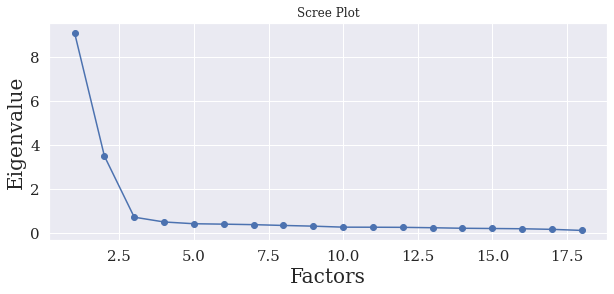

In [15]:
## EFA for X2
efaX1 = ExpFacAn(X1, rot="varimax")

## plot
plt.scatter(range(1,X1.shape[1]+1),efaX1.Eig)
plt.plot(range(1,X1.shape[1]+1),efaX1.Eig)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

% explained:  0.7794936980725443


/home/igodlab/anaconda3/envs/pytorch-env/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


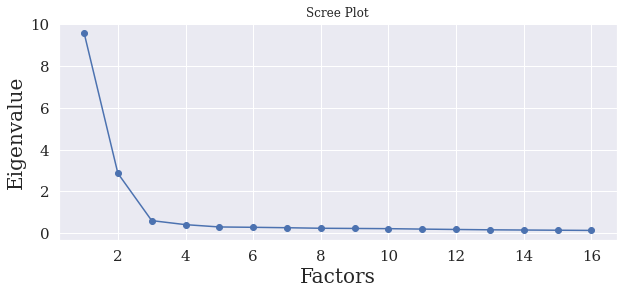

In [16]:
## EFA for X2
efaX2 = ExpFacAn(X2, rot="varimax")

# pprint
print("% explained: ", np.cumsum(efaX2.Eig[:2])[-1]/sum(efaX2.Eig))

## plot
plt.scatter(range(1,X2.shape[1]+1),efaX2.Eig)
plt.plot(range(1,X2.shape[1]+1),efaX2.Eig)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

#savePNG("Scree2020")

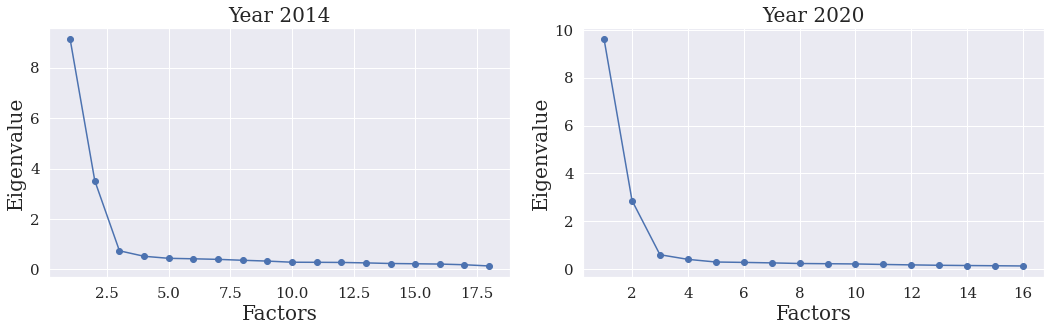

In [17]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

## plot
axes[0].scatter(range(1,X1.shape[1]+1),efaX1.Eig)
axes[0].plot(range(1,X1.shape[1]+1),efaX1.Eig)
axes[0].set_title('Year 2014', size=20)
axes[0].set_xlabel('Factors')
axes[0].set_ylabel('Eigenvalue')


## plot
axes[1].scatter(range(1,X2.shape[1]+1),efaX2.Eig)
axes[1].plot(range(1,X2.shape[1]+1),efaX2.Eig)
axes[1].set_title('Year 2020', size=20)
axes[1].set_xlabel('Factors')
axes[1].set_ylabel('Eigenvalue')

plt.tight_layout()
#savePNG("scree-plots")

# Clustering analysis

In [18]:
from sklearn.cluster import KMeans

In [19]:
## function for metrics
def modelMetrics(model, X, Y):
    predict = model.predict(X)     ## predict outcomes using the test set
    probs   = model.predict_proba(X) ## generate class probabilities

    ## generate evaluation metrics
    jaccScore = metrics.accuracy_score(Y, predict)
    rocScore  = metrics.roc_auc_score(Y, probs[:, 1])

    conf_matrix = metrics.confusion_matrix(Y, predict)
    
    return {"jacc": jaccScore, "roc": rocScore, "confMat": conf_matrix}

In [20]:
#split
X1red = np.array(efaX1.loadings[["Factor 1", "Factor 2"]])
X2red = np.array(efaX2.loadings[["Factor 1", "Factor 2"]])

In [21]:
# k-Means algorithm
km = KMeans(n_clusters=2, random_state=42)

kmFit1 = km.fit_predict(X1red)
kmFit2 = km.fit_predict(X2red)

% 2014 explained:  0.7023070433554797
% 2020 explained:  0.7794936980725443


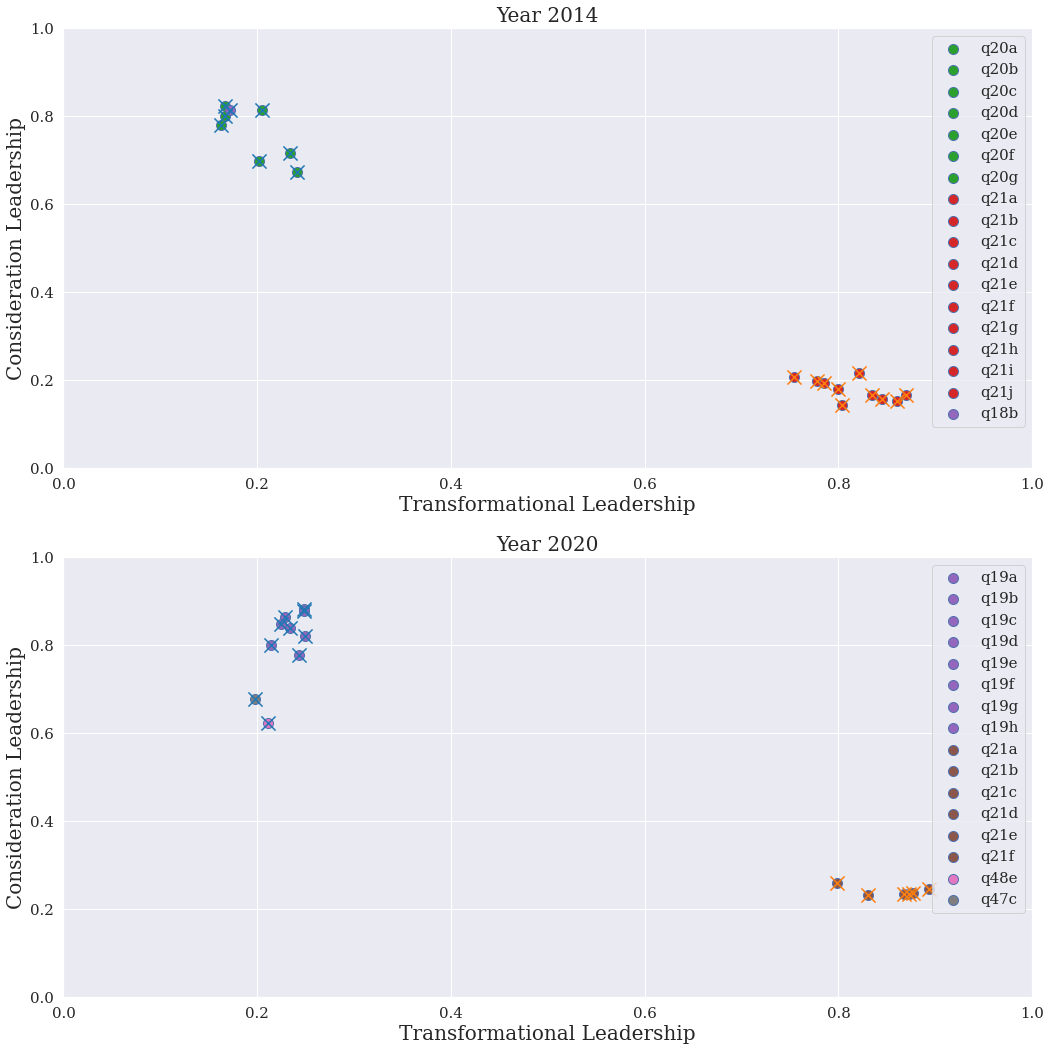

In [22]:
fig, axes = plt.subplots(2,1,figsize=(15,15))

ax_x = "Factor 1"
ax_y = "Factor 2"

color_i = 2

# 2014
# pprint
print("% 2014 explained: ", np.cumsum(efaX1.Eig[:2])[-1]/sum(efaX1.Eig))

axes[0].scatter(efaX1.loadings[ax_x][0],efaX1.loadings[ax_y][0], marker='o', color=cpalette[color_i], s=100, edgecolors='b', label=efaX1.loadings.index[0])
for i in range(1, efaX1.loadings.shape[0]):
    x = efaX1.loadings[ax_x][i]
    y = efaX1.loadings[ax_y][i]
    #z = efaX1.loadings["Factor 3"][i]
    color_i = (color_i % (len(cpalette)-1))
    if efaX1.loadings.index[i-1][2] != efaX1.loadings.index[i][2]:
        color_i += 1
    #color_i += 1
    axes[0].scatter(x,y, marker='o', color=cpalette[color_i], s=100, edgecolors='b', label=efaX1.loadings.index[i])
    

for i in range(efaX1.loadings.shape[0]):
    x = efaX1.loadings[ax_x][i]
    y = efaX1.loadings[ax_y][i]
    
    if kmFit1[i] == 0:
        axes[0].scatter(x,y,marker='x', color=cpalette[0], s=200)
    else:
        axes[0].scatter(x,y,marker='x', color=cpalette[1], s=200)


# 2020

# pprint
color_i = 4
print("% 2020 explained: ", np.cumsum(efaX2.Eig[:2])[-1]/sum(efaX2.Eig))

axes[1].scatter(efaX2.loadings[ax_y][0],efaX2.loadings[ax_x][0], marker='o', color=cpalette[color_i], s=100, edgecolors='b', label=efaX2.loadings.index[0])
for i in range(1, efaX2.loadings.shape[0]):
    x = efaX2.loadings[ax_y][i]
    y = efaX2.loadings[ax_x][i]
    #z = efaX1.loadings["Factor 3"][i]
    color_i = (color_i % (len(cpalette)-1))
    if efaX2.loadings.index[i-1][2] != efaX2.loadings.index[i][2]:
        color_i += 1
    #color_i += 1
    axes[1].scatter(x,y, marker='o', color=cpalette[color_i], s=100, edgecolors='b', label=efaX2.loadings.index[i])
    

for i in range(efaX2.loadings.shape[0]):
    x = efaX2.loadings[ax_y][i]
    y = efaX2.loadings[ax_x][i]
    
    if kmFit2[i] == 0:
        axes[1].scatter(x,y,marker='x', color=cpalette[0], s=200)
    else:
        axes[1].scatter(x,y,marker='x', color=cpalette[1], s=200)
    

axes[0].set_xlabel("Transformational Leadership")
axes[0].set_ylabel("Consideration Leadership")
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
axes[0].legend()
axes[0].set_title("Year 2014", size=20)

axes[1].set_xlabel("Transformational Leadership")
axes[1].set_ylabel("Consideration Leadership")
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1)
axes[1].legend()
axes[1].set_title("Year 2020", size=20)

plt.tight_layout()

#savePNG("FactorAnalysisLFI-2014")

In [23]:
print("2014 score: ",km.score(X1red))
print("2020 score: ",km.score(X2red))

2014 score:  -0.1647442046868483
2020 score:  -0.07814571689390136


# Bootstrapping + Permuting + U-test

## Gender

In [24]:
for j in d14.keys()[:4]:
    print("\n\nPercentage of categories for "+j+": \n", d14[j].value_counts()/d14.shape[0])



Percentage of categories for AS: 
 3.0    0.874155
2.0    0.089383
1.0    0.036462
Name: AS, dtype: float64


Percentage of categories for q1: 
 2.0    0.575610
1.0    0.414571
3.0    0.009820
Name: q1, dtype: float64


Percentage of categories for q2@: 
 2.0    0.472402
1.0    0.381721
3.0    0.145877
Name: q2@, dtype: float64


Percentage of categories for q6@: 
 1.0    0.680990
2.0    0.297861
3.0    0.021149
Name: q6@, dtype: float64


In [25]:
for j in d20.keys()[:4]:
    print("\n\nPercentage of categories for "+j+": \n", d20[j].value_counts()/d20.shape[0])



Percentage of categories for AS: 
 3.0    0.865856
2.0    0.092501
1.0    0.041643
Name: AS, dtype: float64


Percentage of categories for q1: 
 2.0    0.596697
1.0    0.368923
4.0    0.031790
3.0    0.002591
Name: q1, dtype: float64


Percentage of categories for q2@: 
 2.0    0.440773
1.0    0.384373
3.0    0.174853
Name: q2@, dtype: float64


Percentage of categories for q5@: 
 1.0    0.672554
2.0    0.303067
3.0    0.024379
Name: q5@, dtype: float64


In [26]:
## inspect intial distributions
def barCompare(A, B, hueCol=None, xlab=None):
    XA, YA = (A.value_counts()/A.shape[0]).index, (A.value_counts()/A.shape[0]).values
    XB, YB = (B.value_counts()/B.shape[0]).index, (B.value_counts()/B.shape[0]).values
    
    df = pd.DataFrame()
    
    fig, axes = plt.subplots(1,2, figsize=(14,4))

    axes[0].bar(XA, YA)
    axes[1].bar(XB, YB)

    axes[0].set_title("Year 2014", size=20)
    axes[1].set_title("Year 2020", size=20)
        
    if xlab != None:
        axes[0].set_xlabel(xlab)
        axes[1].set_xlabel(xlab)
        
        axes[0].set_ylabel("counts_"+xlab)
        axes[1].set_ylabel("counts_"+xlab)
        
def categoricalDF(dat):
    k = list(dat.keys())
    
    # name columns, this intercalates [key1, "count_"+key1, key2, "count_"+key2, ...]
    newCols = []
    for i in range(len(k)):
        newCols.append(k[i])
        newCols.append("count_"+k[i])
    
    dct = {}
    for i in range(len(newCols)):
        cc = newCols[i]
        if i%2==0:
            dct[cc] = np.array((dat[newCols[i]].value_counts()/dat[newCols[i]].shape[0]).index)
        else:
            dct[cc] = np.array((dat[newCols[i-1]].value_counts()/dat[newCols[i-1]].shape[0]).values)
            
    return dct

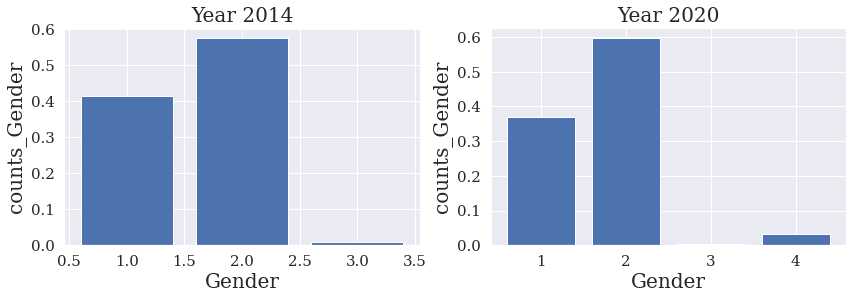

In [27]:
## plot gender
barCompare(d14["q1"], d20["q1"], xlab="Gender")

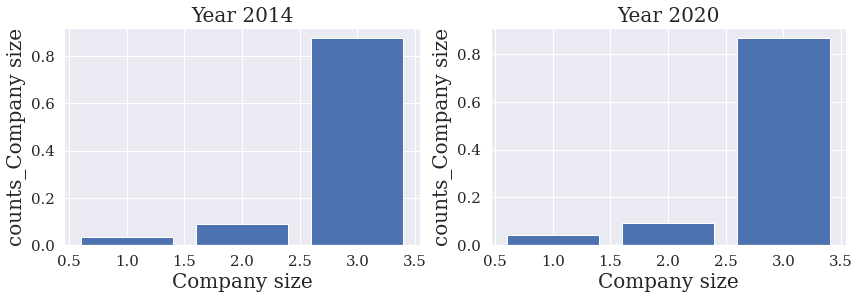

In [28]:
barCompare(d14["AS"], d20["AS"], xlab="Company size")

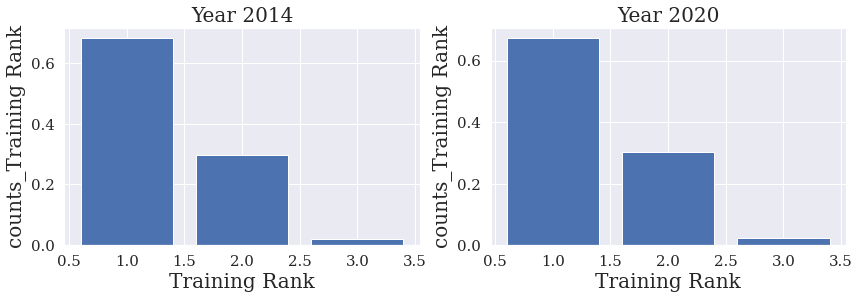

In [29]:
barCompare(d14["q6@"], d20["q5@"], xlab="Training Rank")

In [30]:
np.random.seed(42)
a0 = np.random.choice(range(40,60), replace=True, size=(10,3))
a0

array([[46, 59, 54],
       [50, 47, 46],
       [58, 50, 50],
       [43, 47, 42],
       [41, 51, 45],
       [41, 40, 51],
       [51, 56, 49],
       [55, 54, 54],
       [58, 51, 59],
       [42, 44, 58]])

In [31]:
np.ravel(a0)

array([46, 59, 54, 50, 47, 46, 58, 50, 50, 43, 47, 42, 41, 51, 45, 41, 40,
       51, 51, 56, 49, 55, 54, 54, 58, 51, 59, 42, 44, 58])

In [32]:
b0 = np.random.choice(np.ravel(a0), replace=True, size=(5,3))
b0

array([[58, 49, 50],
       [58, 51, 50],
       [58, 42, 51],
       [51, 51, 50],
       [51, 49, 59]])

In [69]:
def uniquesByCol(x):
    v, c = np.unique(x, return_counts=True)
    return v, c

def proportionKey(ns):
    
    if ns == 0:
        return "0:1"
    elif ns == 1:
        return "1:0"
    # percentages of permutation mixing
    r1 = round(ns, 2)
    r2 = round(1-ns, 2)
    return str(r1)+":"+str(r2)

def PermuteBoostrap(X1, X2, Nboot=50, Nsub=np.array([0,1]), Naccess=None, plot=False, title_=None, ylab=""):
    
    """
    Compute Bootstrap and Permutation from categorical data samples X1 and X2.
    
    
    
    Parameters
    ----------
    X1 : array-like
        Categorical sample 1 to be Bootstrapped and Permuted
    X2 : array-like
        Categorical sample 2 to be Bootstrapped and Permuted
    Nboot : int, optional, default: 1000
        Number of Bootstrap iterations
    Nsub : 1D array-like, optional, default: np.array([0,1])
        Array of permutation percentages for X1, by default 
        the propotion for X2 will be extracted from Nsub, as
        (PS_2014:PS_2020)
    Naccess : optional
    
    """
    
    # number of point accessibles for sampling
    if Naccess == None:
        nAccess = 0.5*min(X1.shape[0], X2.shape[0])
    else:
        nAccess = Naccess

    Len14 = [int(round(nAccess * Nsub[i], 0)) for i in range(len(Nsub))]
    Len20 = [int(round(nAccess * (1-Nsub[i]), 0)) for i in range(len(Nsub))]
    
    ## select gender
    Gender = {}
    CI = {}
    cnt = {}
    alpha = 0.05


    ## Boot
    np.random.seed(42)
    for prop in range(len(Nsub)):
        
        pkey = proportionKey(Nsub[prop])
            
        z = [st.norm.ppf(alpha/2, 0.0, 1.0),st.norm.ppf(1-alpha/2, 0.0, 1.0)]
        boot14_init = np.random.choice(X1, size=(Len14[prop], Nboot), replace=True)
        boot20_init = np.random.choice(X2, size=(Len20[prop], Nboot), replace=True)
        
        bootSamp_init = np.concatenate((boot14_init, boot20_init), axis=0)
        
        bootSamp = np.random.choice(np.ravel(bootSamp_init), replace=True, size=(50000, Nboot))
        Ns = bootSamp.shape[0]
        counts = []
        
        for j in range(Nboot):
            uni = uniquesByCol(bootSamp[:,j])
            counts.append(list(uni[1]))
        counts = np.array(counts)

        Counts = np.mean(counts, axis=0) 
        cnt[pkey] = counts
        Gender[pkey] = Counts/Ns

        ## chi confidence intrvals for means of each category
        CI[pkey] = (Gender[pkey]+z[0]*Gender[pkey]/np.sqrt(Ns), Gender[pkey]+z[1]*Gender[pkey]/np.sqrt(Ns))
    
        # re-structure data for plotting
        Gkeys = list(Gender.keys())

    if plot == True:
        # plot
        X1vals = X1.value_counts()/X1.shape[0]
        X2vals = X2.value_counts()/X2.shape[0]
        x = Nsub
        
        fig, axes = plt.subplots(3,1, figsize=(14,8))
        fig.subplots_adjust(hspace=0.05)
        
        axes[0].set_title(title_, size=20)
        for cat in range(len(Gender[Gkeys[0]])):
            try:
                y       = [Gender[kk][cat] for kk in Gkeys]
                yCIlow  = [CI[kk][0][cat] for kk in Gkeys]
                yCIhigh = [CI[kk][1][cat] for kk in Gkeys]
                
                axes[cat].fill_between(x, yCIlow, yCIhigh, alpha=0.5)
                axes[cat].plot(x, y, '.-', label="Boot")               
                
                
                axes[cat].set_ylabel("% "+ylab[cat])
            except:
                cat -= 1
                pass
        
        axes[0].plot(x, len(x)*[X1vals[1]], "--", label="2014")
        axes[0].plot(x, len(x)*[X2vals[1]], "--", label="2020")
        
        
        axes[1].plot(x, len(x)*[X1vals[2]], "--", label="2014")
        axes[1].plot(x, len(x)*[X2vals[2]], "--", label="2020")
        
        axes[2].plot(x, len(x)*[X1vals[3]], "--", label="2014")
        axes[2].plot(x, len(x)*[X2vals[3]], "--", label="2020")

        plt.legend()
        plt.xticks(x, Gkeys, rotation = 70)
        axes[cat].set_xlabel("Bootstrap Permutation Ratio [$PS_{2014}:PS_{2020}$]")
        plt.show()    

    return Gender, CI, cnt, X2vals

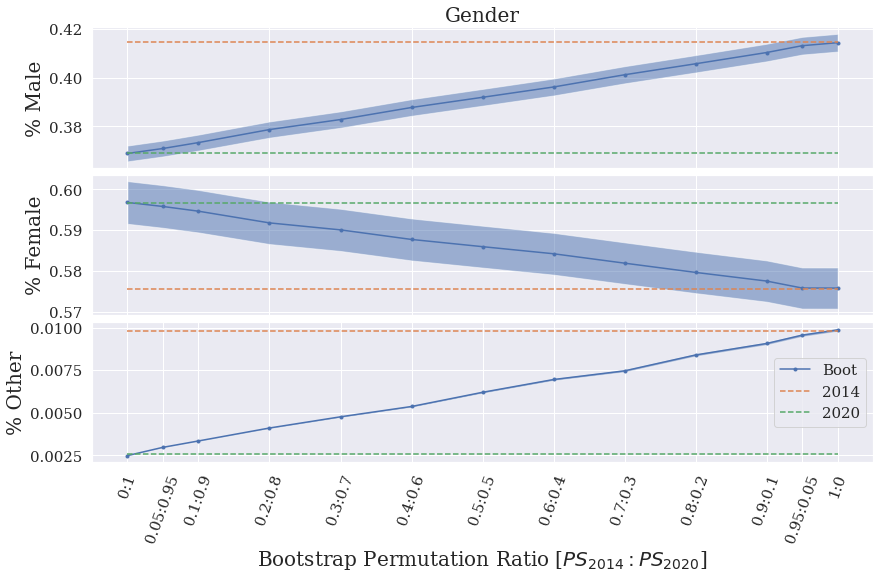

In [70]:
# percentages of permutation samples
nsub = np.array([0, 0.05] + list(np.linspace(0.1, 0.9, 9)) + [0.95, 1])

# gender
gend = PermuteBoostrap(d14["q1"], d20["q1"], Nsub=nsub, title_="Gender", plot=True, ylab=["Male", "Female", "Other"])

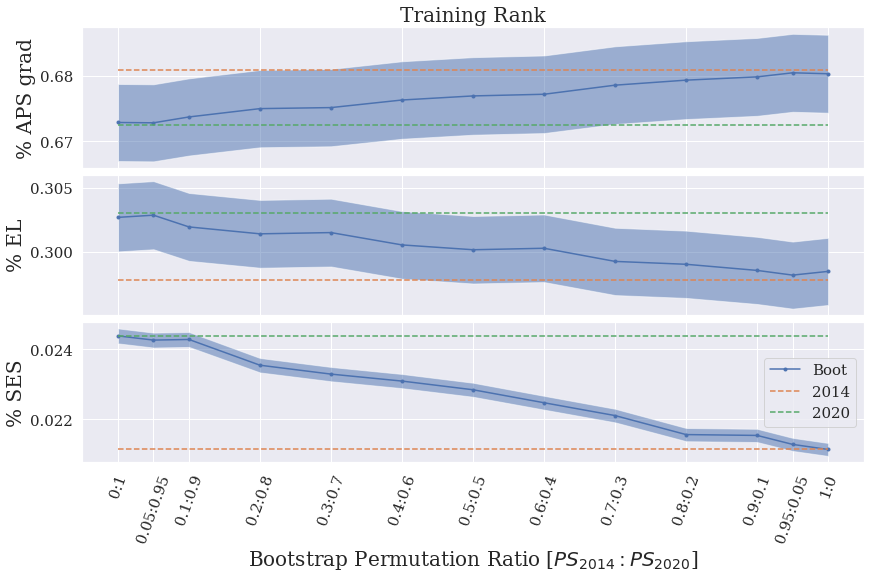

In [71]:
aptrain = PermuteBoostrap(d14["q6@"], d20["q5@"], Nsub=nsub, title_="Training Rank", plot=True, ylab=["APS grad", "EL", "SES"])

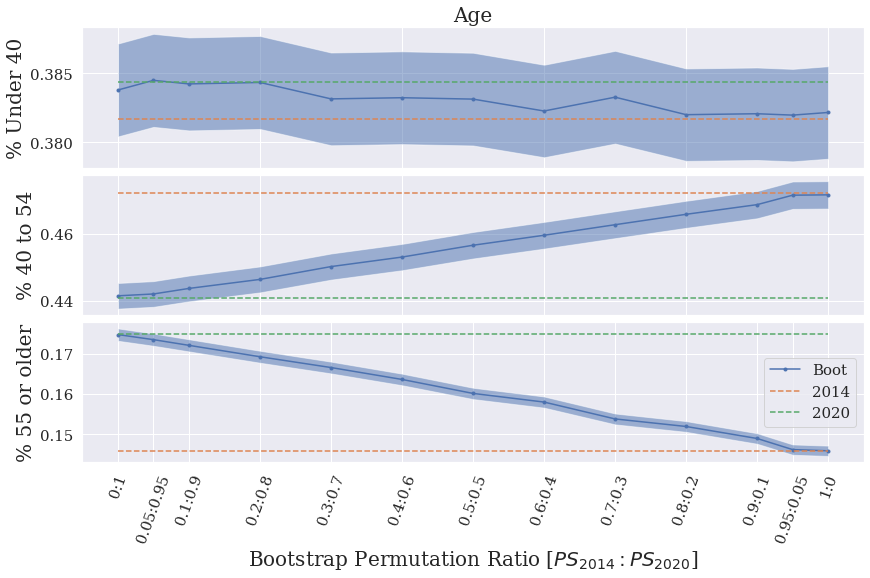

In [72]:
age = PermuteBoostrap(d14["q2@"], d20["q2@"], Nsub=nsub, title_="Age", plot=True, ylab=["Under 40", "40 to 54", "55 or older"])